In [1]:
# Full pipeline

from torch.utils.data import *
from lircst_ana_dataset import LircstAnaDataset
from torch import Generator

dataset = LircstAnaDataset('/home/samnub/dev/lircst-ana/data/')

rand_generator = Generator().manual_seed(42) # The meaning of life, the universe and everything

dataset_train, dataset_valid, dataset_test = random_split(dataset, [0.8, 0.1, 0.1], generator=rand_generator)

print(f"Train set size: {len(dataset_train)}")
print(f"Validation set size: {len(dataset_valid)}")
print(f"Test set size: {len(dataset_test)}")


# Setup Diffusion modules
import pytorch_lightning as pl
from Diffusion.EMA import EMA

train_mode: bool = False
test_afterward: bool = False

#=================================================================================
# Encoded Conditional Diffusion
from encoded_conditional_diffusion import ECDiffusion

model_ECD = ECDiffusion(
    train_dataset=dataset_train,
    valid_dataset=dataset_valid,
    test_dataset=dataset_test,
    lr=1e-4,
    batch_size=16,
)

if not train_mode:
    model_ECD = ECDiffusion.load_from_checkpoint("/home/samnub/dev/lircst-diffusion/src/lightning_logs/version_16/checkpoints/epoch=172-step=200000.ckpt",
                                            train_dataset=dataset_train,
                                            valid_dataset=dataset_valid,
                                            test_dataset=dataset_test,
                                            lr=1e-4,
                                            batch_size=16,)

trainer_ECD = pl.Trainer(
    max_steps=2e5,
    callbacks=[EMA(0.9999)],
    accelerator='gpu',
    devices=[0],
    check_val_every_n_epoch=10,
)

#=================================================================================
# Encoded Conditional Latent Diffusion
from encoded_conditional_latent_diffusion import ECLDiffusion
model_ECLD = ECLDiffusion(
    train_dataset=dataset_train,
    valid_dataset=dataset_valid,
    test_dataset=dataset_test,
    lr=1e-4,
    batch_size=16,
)

if not train_mode:
    model_ECLD = ECLDiffusion.load_from_checkpoint("/home/samnub/dev/lircst-diffusion/src/lightning_logs/version_18/checkpoints/epoch=172-step=200000.ckpt",
                                            train_dataset=dataset_train,
                                            valid_dataset=dataset_valid,
                                            test_dataset=dataset_test,
                                            lr=1e-4,
                                            batch_size=16,)

trainer_ECLD = pl.Trainer(
    max_steps=2e5,
    callbacks=[EMA(0.9999)],
    accelerator='gpu',
    devices=[0],
    check_val_every_n_epoch=10,
)

#=================================================================================

if train_mode:
    # Train the models
    trainer_ECD.fit(model_ECD)
    trainer_ECLD.fit(model_ECLD)

if test_afterward:
    # Test the models
    trainer_ECD.test(model_ECD)
    trainer_ECLD.test(model_ECLD)

Train set size: 14828
Validation set size: 1853
Test set size: 1853


/home/samnub/anaconda3/envs/lircst-diffusion/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Is Time embed used ?  True
Is Time embed used ?  True


/home/samnub/dev/lircst-diffusion/src/Diffusion/EMA.py:58: UserWarning: EMA has better performance when Apex is installed: https://github.com/NVIDIA/apex#installation.
  rank_zero_warn(
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Is Time embed used ?  True
Is Time embed used ?  True


You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Random dataset index: 17899


diffusion sampling: 100%|██████████| 200/200 [00:06<00:00, 29.09it/s]


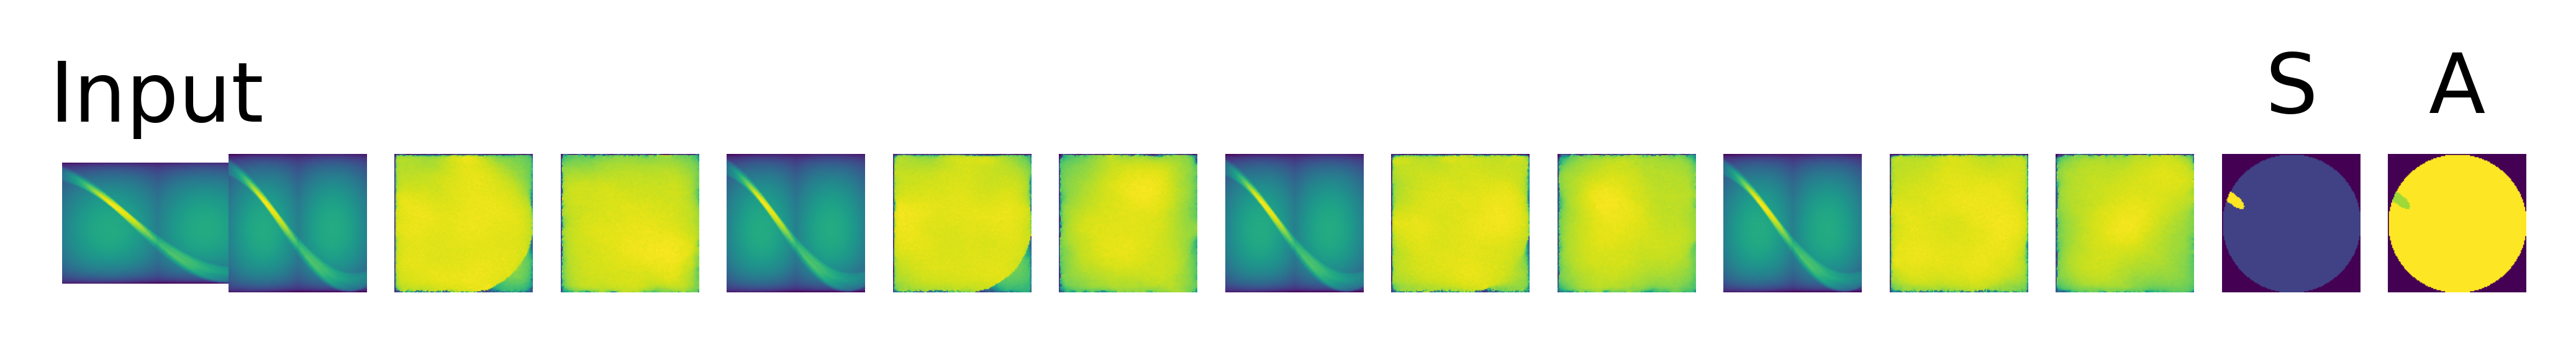

SSIM For first in batch:
Scatter channel: 0.035613805949034884
Attenuation channel: -0.05196062497661443


diffusion sampling: 100%|██████████| 200/200 [00:02<00:00, 75.49it/s]


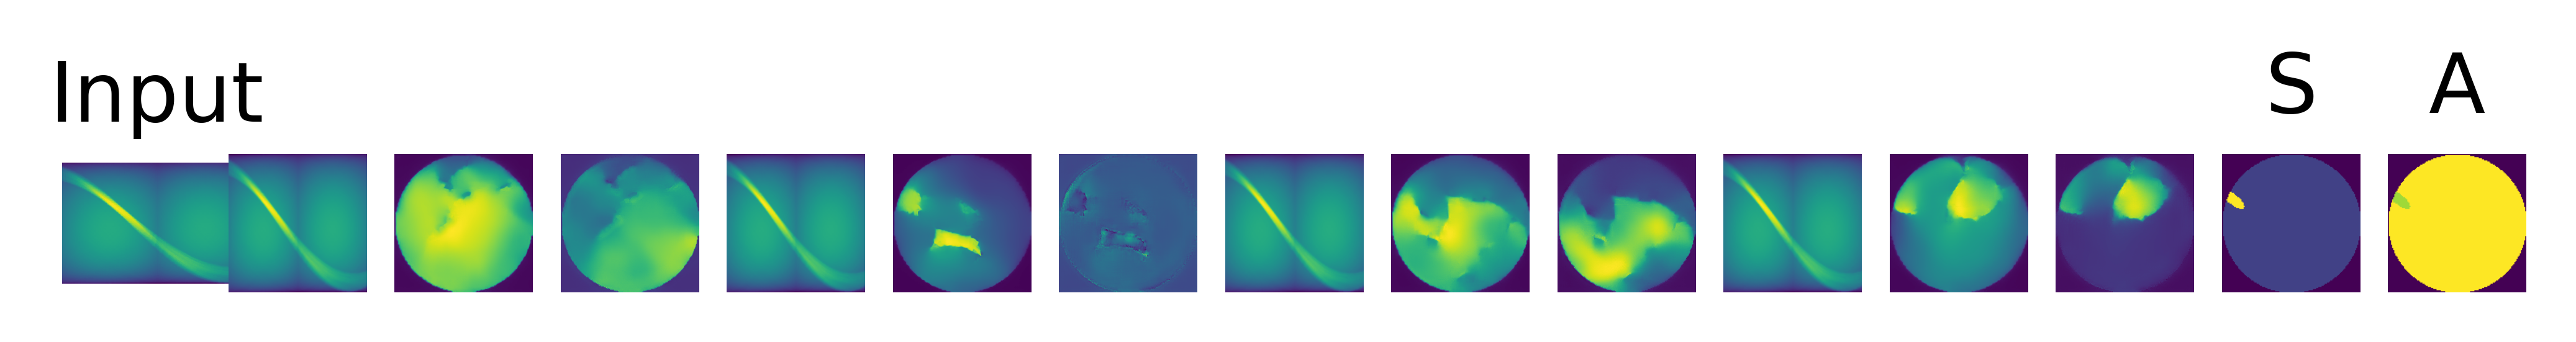

SSIM For first in batch:
Scatter channel: -0.20003017440161083
Attenuation channel: 0.09436617359558942


In [7]:
# Display some samples from each model
import matplotlib.pyplot as plt
import numpy as np
import torch
from skimage.metrics import structural_similarity as ssim

def show_samples(model: ECDiffusion|ECLDiffusion, dataset_idx: int|None=None, num_samples=4):
    phan, sino, _ = dataset[np.random.randint(0, len(dataset)) if dataset_idx is None else dataset_idx]
    sino = torch.from_numpy(sino)
    batch_input = torch.stack(num_samples*[sino]).cuda()

    out, encoded_condition = model(batch_input, verbose=True)

    plt.figure(dpi=800)
    plt.subplot(1,3+len(out)*2,1)
    plt.imshow(torch.sum(sino, axis=2))
    plt.title('Input')
    plt.axis('off')
    for idx in range(out.shape[0]*3):
        if idx % 3 == 1:
            continue
        if idx % 3 == 2:
            continue
        plt.subplot(1,3+len(out)*3,idx+2)
        plt.imshow(torch.sum(encoded_condition[idx//3].detach().cpu(), axis=0))
        plt.axis('off')
        plt.subplot(1,3+len(out)*3,idx+3)
        plt.imshow(out[idx//3].detach().cpu()[0])
        plt.axis('off')
        plt.subplot(1,3+len(out)*3,idx+4)
        plt.imshow(out[idx//3].detach().cpu()[1])
        plt.axis('off')
    plt.subplot(1,3+len(out)*3,2+len(out)*3)
    plt.imshow(phan[0])
    plt.title('S')
    plt.axis('off')
    plt.subplot(1,3+len(out)*3,3+len(out)*3)
    plt.imshow(phan[1])
    plt.title('A')
    plt.axis('off')
    plt.show()

    def compare_images(imageA, imageB):
        # Compute SSIM between two images
        
        # If images aren't the same size, resize them
        if imageA.shape != imageB.shape:
            imageA = np.resize(imageA, imageB.shape)

        # P.S. Scikit-image returns a value between -1 and 1, where 1 is a perfect match and -1 is a complete mismatch
        s = ssim(imageA, 
                imageB, 
                multichannel=True,
                data_range=imageB.max() - imageB.min())
        return s
    
    print("SSIM For first in batch:")
    print(f"Scatter channel: {compare_images(out[0].detach().cpu().numpy()[0], phan[0])}")
    print(f"Attenuation channel: {compare_images(out[0].detach().cpu().numpy()[1], phan[1])}")

random_idx = np.random.randint(0, len(dataset))
print(f"Random dataset index: {random_idx}")

show_samples(model_ECD, dataset_idx=random_idx)
show_samples(model_ECLD, dataset_idx=random_idx)